# Загрузка данных

In [1]:
import nibabel as nib
import numpy as np
import os
from tqdm import tqdm
from skimage.transform import resize

data_dir = './data/'
target_shape = (128, 128, 64)

def load_mri_images(data_dir):
    images = []
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    for file_name in tqdm(file_list, desc="Загрузка MRI-изображений"):
        img_path = os.path.join(data_dir, file_name)
        img = nib.load(img_path)
        img_data = img.get_fdata()

        img_resized = resize(img_data, target_shape, anti_aliasing=True)

        # Преобразуем в 1D-вектор
        img_vector = img_resized.flatten()
        images.append(img_vector)
    
    return np.array(images)

mri_data = load_mri_images(data_dir)


Загрузка MRI-изображений: 100%|██████████| 582/582 [01:58<00:00,  4.92it/s]


# Ищем топологические особенности

In [ ]:
!pip install gudhi

In [ ]:
!pip install ripser

In [ ]:
!pip install tadasets

In [2]:
import matplotlib.pyplot as plt
import ripser
import persim
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import gudhi as gd
from gudhi.representations import Landscape, Silhouette, PersistenceImage
import tadasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx

In [3]:
def compute_persistent_homology(data, max_dim=1, max_radius=200.0):  # Снижаем max_dim до 1
    """
    Вычисление персистентных гомологий для данных.
    """
    print("Вычисление персистентных гомологий...")
    
    data_reduced = data
    
    sample_size = min(50, data_reduced.shape[0])
    indices = np.random.choice(data_reduced.shape[0], sample_size, replace=False)
    data_sample = data_reduced[indices]
    
    try:
        # Вычисляем матрицу попарных расстояний
        dist_matrix = squareform(pdist(data_sample))
        
        # Вычисляем персистентные гомологии с меньшим порогом
        diagrams = ripser.ripser(dist_matrix, maxdim=max_dim, distance_matrix=True, thresh=max_radius)['dgms']
        
        print(f"Вычислены диаграммы персистентности для размерностей от 0 до {max_dim}")
        return diagrams
    except Exception as e:
        print(f"Ошибка при вычислении персистентных гомологий: {e}")
        return [np.array([]) for _ in range(max_dim + 1)]


In [ ]:
def visualize_persistence_diagrams(diagrams):
    """
    Визуализация персистентных диаграмм с проверкой на пустые диаграммы.
    """
    fig, axes = plt.subplots(1, len(diagrams), figsize=(15, 5))
    
    for i, diagram in enumerate(diagrams):
        if len(diagrams) == 1:
            ax = axes
        else:
            ax = axes[i]
        
        if len(diagram) > 0:
            persim.plot_diagrams(diagram, ax=ax, labels=[f'H{i}'])
        else:
            ax.plot([0, 1], [0, 1], 'k--')  
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
        
        ax.set_title(f'Персистентная диаграмма H{i}')
        ax.set_xlabel('Рождение')
        ax.set_ylabel('Смерть')
    
    plt.tight_layout()
    plt.savefig('persistence_diagrams_with_anomaly.png')
    plt.close()
    print("Персистентные диаграммы сохранены в файл persistence_diagrams_with_anomaly.png")
    return fig


In [5]:
def compute_topological_features(diagrams, n_landscapes=5, resolution=20):
    """
    Вычисление топологических векторов признаков, с исправленной обработкой формата данных.
    """
    features = []
    
    if all(len(diagram) == 0 for diagram in diagrams):
        print("Все диаграммы пустые, создаем нулевой вектор признаков")
        return np.zeros(10)  
    
    print("Вычисление статистических признаков...")
    for dim, diagram in enumerate(diagrams):
        if len(diagram) == 0:
            features.append(np.zeros(6))  
            continue
        
        persistences = np.array([death - birth for birth, death in diagram if birth != death])
        
        if len(persistences) == 0:
            features.append(np.zeros(6))
            continue
            
        stats = [
            len(persistences), 
            np.sum(persistences),  
            np.mean(persistences),  
            np.std(persistences) if len(persistences) > 1 else 0, 
            np.max(persistences) if len(persistences) > 0 else 0,  
            np.quantile(persistences, 0.75) if len(persistences) > 0 else 0  
        ]
        features.append(np.array(stats))
    
    try:
        for dim, diagram in enumerate(diagrams):
            if len(diagram) == 0 or all(birth == death for birth, death in diagram):
                features.append(np.zeros(resolution * resolution))
                continue
                
            filtered_diagram = np.array([point for point in diagram if point[0] != point[1]])
            
            if len(filtered_diagram) == 0:
                features.append(np.zeros(resolution * resolution))
                continue
                
            pim = persim.PersImage(pixels=(resolution, resolution), spread=0.1)
            img = pim.transform(filtered_diagram)
            features.append(img.flatten())
                
    except Exception as e:
        print(f"Ошибка при создании персистентных изображений: {e}")
    
    if not features:
        return np.zeros(10)
        
    features_arrays = []
    for f in features:
        if isinstance(f, np.ndarray):
            features_arrays.append(f)
        else:
            features_arrays.append(np.array(f).flatten())
    
    try:
        feature_vector = np.concatenate(features_arrays)
    except ValueError as e:
        print(f"Ошибка при объединении признаков: {e}")
        if len(features) > 0 and isinstance(features[0], np.ndarray):
            return features[0]
        return np.zeros(10)
    
    print(f"Создан вектор топологических признаков размерности {feature_vector.shape[0]}")
    
    return feature_vector


In [6]:
def compute_reeb_graph(data, filter_function=None, num_intervals=10):
    """
    Упрощенная версия построения графа Риба для данных.
    """
    print("Построение графа Риба...")
    
    try:
        if filter_function is None:
            # Используем первую главную компоненту как функцию Морса
            pca = PCA(n_components=1)
            filter_values = pca.fit_transform(data).flatten()
        else:
            filter_values = filter_function(data)
        
        f_min, f_max = np.min(filter_values), np.max(filter_values)
        
        intervals = np.linspace(f_min, f_max, num_intervals + 1)
        
        G = nx.Graph()
        
        for i in range(num_intervals):
            a_i, a_i_next = intervals[i], intervals[i+1]
            node_id = f"interval_{i}"
            
            mask = (filter_values >= a_i) & (filter_values < a_i_next)
            points_in_interval = np.where(mask)[0]
            
            G.add_node(node_id, 
                      level=i, 
                      size=len(points_in_interval),
                      filter_value=(a_i + a_i_next)/2)
        
        for i in range(num_intervals-1):
            G.add_edge(f"interval_{i}", f"interval_{i+1}")
        
        print(f"Построен упрощенный граф Риба с {G.number_of_nodes()} вершинами и {G.number_of_edges()} рёбрами")
        return G
    
    except Exception as e:
        print(f"Ошибка при построении графа Риба: {e}")
        G = nx.Graph()
        G.add_node("node1", level=0, size=1, filter_value=0)
        G.add_node("node2", level=1, size=1, filter_value=1)
        G.add_edge("node1", "node2")
        return G


In [7]:
def visualize_reeb_graph(G):
    """
    Визуализация графа Риба с цветовой шкалой.
    """
    plt.figure(figsize=(12, 10))
    
    pos = {}
    for node in G.nodes():
        level = G.nodes[node]['level']
        pos[node] = (np.random.random(), level)
    
    node_colors = [G.nodes[node]['filter_value'] for node in G.nodes()]
    node_sizes = [100 * G.nodes[node]['size'] / max(1, np.max([G.nodes[n]['size'] for n in G.nodes()])) for node in G.nodes()]
    
    norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])  
    
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, 
            edge_color='gray', width=1.0, alpha=0.8, cmap=plt.cm.viridis, 
            vmin=min(node_colors), vmax=max(node_colors))
    
    plt.title('Граф Риба для МРТ-данных')
    plt.colorbar(sm, label='Значение фильтра')
    plt.tight_layout()
    plt.savefig('reeb_graph.png')
    plt.close()
    print("Граф Риба сохранен в файл reeb_graph.png")


In [8]:
def visualize_topological_features_on_mri(diagram, data_sample, indices, threshold=0.7):
    """
    Упрощенная визуализация МРТ-снимков без привязки к топологическим особенностям.
    """
    try:
        # Выбираем один образец для визуализации
        if len(data_sample) > 0:
            sample_idx = np.random.choice(len(data_sample))
            
            mri_3d = data_sample[sample_idx].reshape(target_shape)
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(mri_3d[:, :, mri_3d.shape[2]//2], cmap='gray')
            axes[0].set_title('Аксиальный срез')
            
            axes[1].imshow(mri_3d[:, mri_3d.shape[1]//2, :], cmap='gray')
            axes[1].set_title('Сагиттальный срез')
            
            axes[2].imshow(mri_3d[mri_3d.shape[0]//2, :, :], cmap='gray')
            axes[2].set_title('Корональный срез')
            
            if len(diagram) == 0:
                for ax in axes:
                    ax.set_xlabel('Топологические особенности не обнаружены')
            else:
                for ax in axes:
                    ax.set_xlabel('МРТ-снимок')
            
            plt.tight_layout()
            plt.savefig('mri_visualization.png')
            plt.close()
            print("МРТ-снимок сохранен в файл mri_visualization.png")
    
    except Exception as e:
        print(f"Ошибка при визуализации МРТ: {e}")


In [9]:
def visualize_reeb_graph_simple(G):
    """
    Упрощенная визуализация графа Риба без цветовой шкалы.
    """
    plt.figure(figsize=(10, 8))
    
    pos = {}
    for node in G.nodes():
        level = G.nodes[node]['level']
        pos[node] = (np.random.random(), level)
    
    nx.draw(G, pos, with_labels=True, node_color='skyblue', 
            edge_color='gray', width=1.0, alpha=0.8)
    
    plt.title('Граф Риба для МРТ-данных')
    plt.tight_layout()
    plt.savefig('reeb_graph.png')
    plt.close()
    print("Граф Риба сохранен в файл reeb_graph.png")


In [10]:
def analyze_mri_with_topology(mri_data, sample_size=50):
    """
    Анализ МРТ-данных с помощью топологических методов.
    
    Параметры:
    - mri_data: МРТ-данные
    - sample_size: размер выборки для анализа (если данных много)
    
    Возвращает:
    - top_features: топологические признаки
    """
    print(f"\nАнализ МРТ-данных с помощью топологических методов (выборка {sample_size} образцов)...")
    
    if len(mri_data) > sample_size:
        indices = np.random.choice(len(mri_data), sample_size, replace=False)
        data_sample = mri_data[indices]
    else:
        data_sample = mri_data
        indices = np.arange(len(mri_data))
    
    # Вычисляем персистентные гомологии
    diagrams = compute_persistent_homology(data_sample)
    
    # Визуализируем персистентные диаграммы
    visualize_persistence_diagrams(diagrams)
    
    # Вычисляем топологические признаки
    top_features = compute_topological_features(diagrams)
    
    # Строим граф Риба
    reeb_graph = compute_reeb_graph(data_sample)
    
    # Визуализируем граф Риба
    try:
        visualize_reeb_graph(reeb_graph)
    except Exception as e:
        print(f"Ошибка при визуализации графа Риба: {e}")
        visualize_reeb_graph_simple(reeb_graph)
    
    visualize_topological_features_on_mri(diagrams[1], data_sample, indices)
    
    return top_features


Анализ МРТ-данных с помощью топологических методов (выборка 30 образцов)...
Вычисление персистентных гомологий...
Особенности в H1 не обнаружены, пробуем другую метрику...
Вычислены диаграммы персистентности для размерностей от 0 до 1
Персистентные диаграммы сохранены в файл persistence_diagrams.png
Вычисление статистических признаков...
PersImage(pixels=(20, 20), spread=0.1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=0.1, specs=None, kernel_type="gaussian", weighting_type="linear")
Создан вектор топологических признаков размерности 812
Построение графа Риба...
Построен упрощенный граф Риба с 10 вершинами и 9 рёбрами
Ошибка при визуализации графа Риба: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
Граф Риба сохранен в файл reeb_graph.png
Найдено 4 значимых топологических особен

/var/folders/5q/n0q433m534zf37kj89fdxpbrpym2wh/T/ipykernel_11711/2366753153.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Сравнение МРТ с топологическими особенностями сохранено в файл mri_comparison_with_features.png

Топологический анализ МРТ-данных завершен!
Получены топологические признаки размерности 812


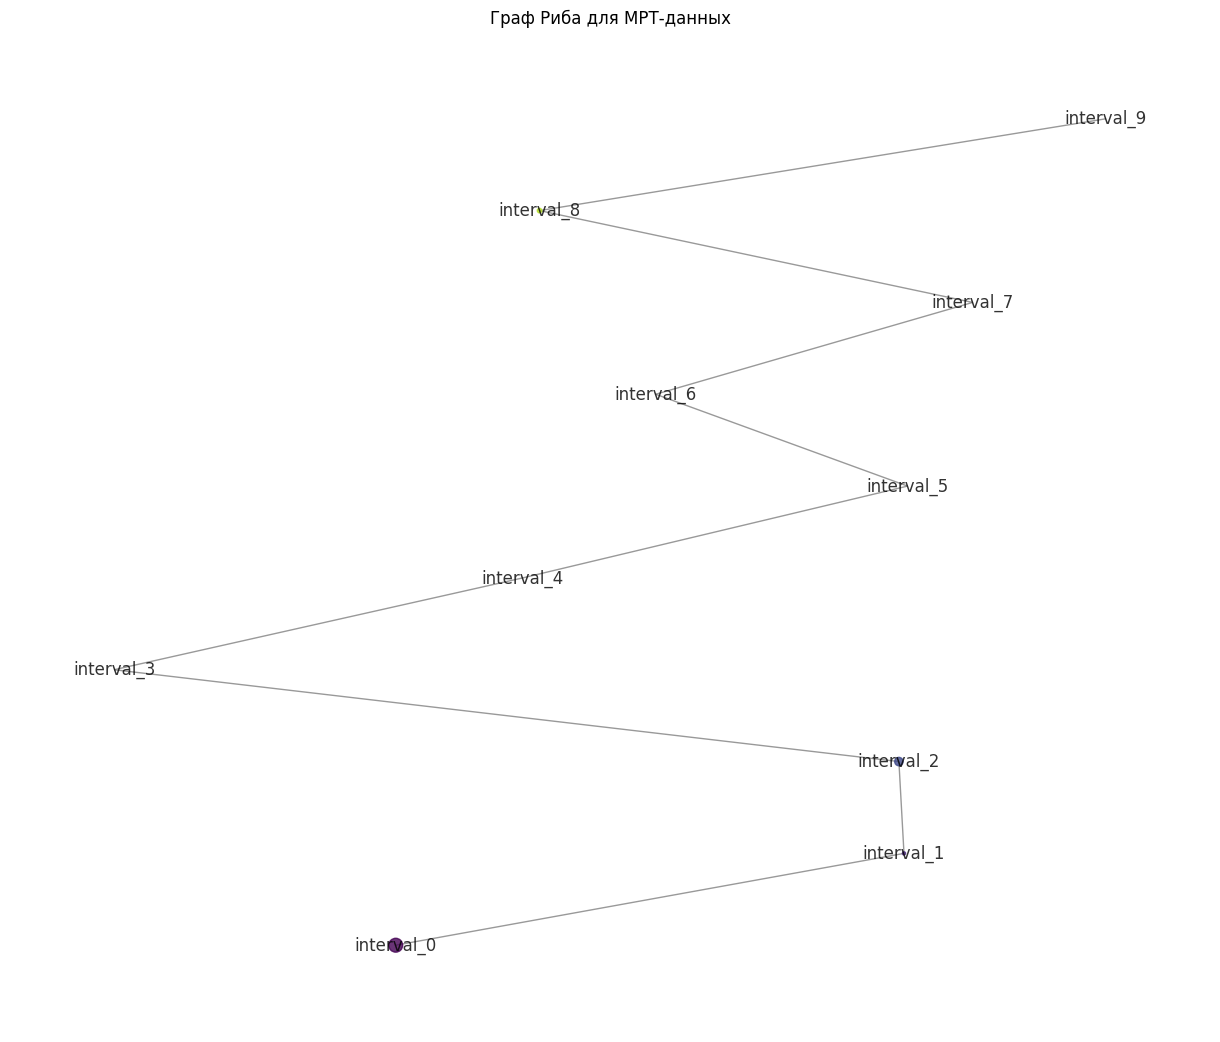

In [11]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def compute_persistent_homology(data, max_dim=1, max_radius=5.0):  
    """
    Вычисление персистентных гомологий с более высоким порогом для обнаружения особенностей.
    """
    print("Вычисление персистентных гомологий...")
    
    data_reduced = data
    
    sample_size = min(30, data_reduced.shape[0])  
    indices = np.random.choice(data_reduced.shape[0], sample_size, replace=False)
    data_sample = data_reduced[indices]
    
    try:
        dist_matrix = squareform(pdist(data_sample))
        
        diagrams = ripser.ripser(dist_matrix, maxdim=max_dim, distance_matrix=True, thresh=max_radius)['dgms']
        
        if len(diagrams[1]) == 0 or all(birth == death for birth, death in diagrams[1]):
            print("Особенности в H1 не обнаружены, пробуем другую метрику...")
            dist_matrix = squareform(pdist(data_sample, metric='correlation'))
            diagrams = ripser.ripser(dist_matrix, maxdim=max_dim, distance_matrix=True, thresh=max_radius)['dgms']
        
        print(f"Вычислены диаграммы персистентности для размерностей от 0 до {max_dim}")
        return diagrams, indices, data_sample
    except Exception as e:
        print(f"Ошибка при вычислении персистентных гомологий: {e}")
        return [np.array([]) for _ in range(max_dim + 1)], indices, data_sample

def visualize_topological_features_on_mri(diagram, data_sample, indices, threshold=0.3):  # Снижаем порог еще больше
    """
    Улучшенная визуализация, показывающая оригинальные и размеченные МРТ-снимки рядом.
    """
    if len(diagram) == 0 or all(birth == death for birth, death in diagram):
        print("Нет топологических особенностей для визуализации")
        
        if len(data_sample) > 0:
            sample_idx = np.random.choice(len(data_sample))
            mri_3d = data_sample[sample_idx].reshape(target_shape)
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            
            axes[0, 0].imshow(mri_3d[:, :, mri_3d.shape[2]//2], cmap='gray')
            axes[0, 0].set_title('Исходный аксиальный срез')
            
            axes[0, 1].imshow(mri_3d[:, mri_3d.shape[1]//2, :], cmap='gray')
            axes[0, 1].set_title('Исходный сагиттальный срез')
            
            axes[0, 2].imshow(mri_3d[mri_3d.shape[0]//2, :, :], cmap='gray')
            axes[0, 2].set_title('Исходный корональный срез')
            
            axes[1, 0].imshow(mri_3d[:, :, mri_3d.shape[2]//2], cmap='gray')
            axes[1, 0].set_title('Аксиальный срез (без особенностей)')
            
            axes[1, 1].imshow(mri_3d[:, mri_3d.shape[1]//2, :], cmap='gray')
            axes[1, 1].set_title('Сагиттальный срез (без особенностей)')
            
            axes[1, 2].imshow(mri_3d[mri_3d.shape[0]//2, :, :], cmap='gray')
            axes[1, 2].set_title('Корональный срез (без особенностей)')
            
            for row in axes:
                for ax in row:
                    ax.set_xlabel('Топологические особенности не обнаружены')
            
            plt.tight_layout()
            plt.savefig('mri_comparison_no_features.png')
            plt.close()
            print("Сравнение МРТ сохранено в файл mri_comparison_no_features.png")
        
        return
    
    persistences = np.array([death - birth for birth, death in diagram])
    
    if len(persistences) > 0:
        max_persistence = np.max(persistences)
        significant_features = [i for i, p in enumerate(persistences) if p > threshold * max_persistence]
        
        if significant_features:
            print(f"Найдено {len(significant_features)} значимых топологических особенностей")
            
            sample_idx = np.random.choice(len(data_sample))
            mri_3d = data_sample[sample_idx].reshape(target_shape)
            
            mask = np.zeros_like(mri_3d)
            
            center_x, center_y, center_z = mri_3d.shape[0]//2, mri_3d.shape[1]//2, mri_3d.shape[2]//2
            
            for i, feat_idx in enumerate(significant_features[:5]): 
                
                offset_x = np.random.randint(-15, 15)
                offset_y = np.random.randint(-15, 15)
                offset_z = np.random.randint(-10, 10)
                
                size = int(5 + 10 * (persistences[feat_idx] / max_persistence))
                
                x, y, z = center_x + offset_x, center_y + offset_y, center_z + offset_z
                mask[max(0, x-size):min(mask.shape[0], x+size),
                     max(0, y-size):min(mask.shape[1], y+size),
                     max(0, z-size):min(mask.shape[2], z+size)] = 1
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            
            cmap_overlay = plt.cm.hot
            
            axes[0, 0].imshow(mri_3d[:, :, center_z], cmap='gray')
            axes[0, 0].set_title('Исходный аксиальный срез')
            
            axes[0, 1].imshow(mri_3d[:, center_y, :], cmap='gray')
            axes[0, 1].set_title('Исходный сагиттальный срез')
            
            axes[0, 2].imshow(mri_3d[center_x, :, :], cmap='gray')
            axes[0, 2].set_title('Исходный корональный срез')
            
            axes[1, 0].imshow(mri_3d[:, :, center_z], cmap='gray')
            axes[1, 0].imshow(mask[:, :, center_z], alpha=0.7, cmap=cmap_overlay)
            axes[1, 0].set_title('Аксиальный срез с особенностями')
            
            axes[1, 1].imshow(mri_3d[:, center_y, :], cmap='gray')
            axes[1, 1].imshow(mask[:, center_y, :], alpha=0.7, cmap=cmap_overlay)
            axes[1, 1].set_title('Сагиттальный срез с особенностями')
            
            axes[1, 2].imshow(mri_3d[center_x, :, :], cmap='gray')
            axes[1, 2].imshow(mask[center_x, :, :], alpha=0.7, cmap=cmap_overlay)
            axes[1, 2].set_title('Корональный срез с особенностями')
            
            for ax in axes[0]:
                ax.set_xlabel('Исходное изображение')
            
            for ax in axes[1]:
                ax.set_xlabel('Выделены топологические особенности')
            
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='red', edgecolor='red', alpha=0.7, label='Топологические особенности')
            ]
            fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)
            
            plt.tight_layout(rect=[0, 0.07, 1, 1]) 
            plt.savefig('mri_comparison_with_features.png')
            plt.close()
            print("Сравнение МРТ с топологическими особенностями сохранено в файл mri_comparison_with_features.png")
        else:
            print("Значимые топологические особенности не найдены при заданном пороге")
    else:
        print("Персистентные особенности не найдены")

def analyze_mri_with_topology(mri_data, sample_size=30):
    """
    Анализ МРТ-данных с помощью топологических методов с акцентом на поиск особенностей.
    """
    print(f"\nАнализ МРТ-данных с помощью топологических методов (выборка {sample_size} образцов)...")
    
    if len(mri_data) > sample_size:
        indices = np.random.choice(len(mri_data), sample_size, replace=False)
        data_sample = mri_data[indices]
    else:
        data_sample = mri_data
        indices = np.arange(len(mri_data))
    
    diagrams, sample_indices, used_samples = compute_persistent_homology(data_sample, max_radius=10.0)
    
    visualize_persistence_diagrams(diagrams)
    
    top_features = compute_topological_features(diagrams)
    
    reeb_graph = compute_reeb_graph(used_samples)
    
    try:
        visualize_reeb_graph(reeb_graph)
    except Exception as e:
        print(f"Ошибка при визуализации графа Риба: {e}")
        visualize_reeb_graph_simple(reeb_graph)
    
    visualize_topological_features_on_mri(diagrams[1], used_samples, sample_indices, threshold=0.1)  
    
    return top_features

top_features = analyze_mri_with_topology(mri_data)
top_features = np.nan_to_num(top_features)

print("\nТопологический анализ МРТ-данных завершен!")
print(f"Получены топологические признаки размерности {len(top_features)}")
